# FEATURE ENGINEERING & DATA PRE-PROCESSING

**Aim of the Notebook**: Feature engineering and Data Pre-Processing are the most significant topics in data science. In a general opinion, %80 of the work is data preprocessing, and %20 of the work is modeling in a machine learning project, therefore, there are issues to be considered. The aim of this notebook is to be a tutorial on the approach to data preparation. 

First of all, check the what is the difference between feature engineering and data preprocessing.

**Feature Engineering:** The work performed on the features (such as preprocessing, generating a new variable, etc.), and generating variables from raw data.

**Data Preprocessing:** The process of making the data suitable before implementing a model.

Actually, the aim is similar, make the dataset become much more suitable, and prepare it for the model. The difference can be shown in a figure:

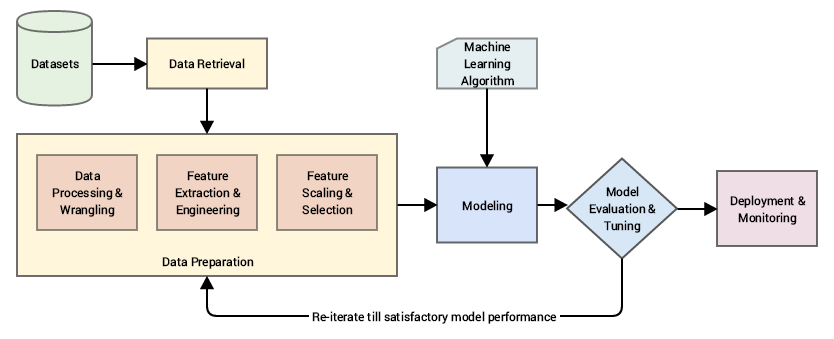

In this step, there are 4 topics to consider and handle to prepare the dataset.
1. Outliers
2. Missing Values
3. Feature Extraction
4. Encoding & Scaling

All of these are the steps of data preprocessing and feature engineering, and each of them will be explained in the notebook.

Obviously, before the process, the dataset has to be explored, and the variables have to be understood. That means the dataset has to be prepared before preparing. Make ready to your popcorns for the movie named "Inception on Data Science"! Of course, it does not that hard, but there are rules and steps to be followed in order to not get lost.

## Table of Contents

### 1. [First look to the dataset](#1)
### 2. [EDA (Exploratory Data Analysis)](#2)
* 2.1 [Analyse outliers and missing values](#2.1)

### 3. [Pre-processing (Outliers and Missing Values)](#3)
### 4. [Feature Extraction](#4)
### 5. [Encoding & Scaling](#5)
### 6. [Modeling](#6)

<a id="1"></a> <br>
# 1. First look to the Dataset

**Business Problem:** It is desired to develop a machine learning model that can predict whether people have diabetes when their characteristics are specified. You are expected to perform the necessary data analysis and feature engineering steps before developing the model.

**Story of Dataset:** The dataset is part of the large dataset held at the National Institutes of Diabetes-Digestive-Kidney Diseases in the USA. Data used for diabetes research on Pima Indian women aged 21 and over living in Phoenix, the 5th largest city of the State of Arizona in the USA.

**Variables:** The target variable is specified as **"outcome"**; **1** indicates **positive** diabetes test result, **0** indicates **negative**.


- **Pregnancies:** The number of pregnancies
- **Glucose:** 2-hour plasma glucose concentration in the oral glucose tolerance test
- **Blood Pressure:** Blood Pressure (Small blood pressure) (mmHg)
- **SkinThickness:** Skin Thickness
- **Insulin:** 2-hour serum insulin (mu U/ml)
- **DiabetesPedigreeFunction:** A function that calculates the probability of having diabetes according to the descendants
- **BMI:** Body mass index
- **Age:** Age (year)
- **Outcome:** Have the disease (1) or not (0)

<a id="2"></a> <br>
# 2. EDA (Exploratory Data Analysis)

This is the part of the explore the dataset. The outliers and missing value analyses will be done in this part but the only point is to observe these in this part. The operation and editing for these will be done in Part 3: Pre-processing.

In [83]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [84]:
# Adjustment of visibility of Datafreames
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [85]:
df = pd.read_csv("../input/diabetes/diabetes.csv")
df.head()

In [86]:
print("##################### Shape #####################")
print(df.shape)
print("##################### Types #####################")
print(df.dtypes)
print("##################### NA #####################")
print(df.isnull().sum())
print("##################### Quantiles #####################")
print(df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)  # sayısal değişkenlerin dağılım bilgisi

In [87]:
df.describe().T

Now, we looked at the data and checked the variables. The first step is to go deeper and understand the variables. Here, the questions have to be asked: "which variables are _really_ numerical, and which of these are categorical? Is there any cardinal variable?".

For instance, the target variable, Outcome, seems as a numerical variable, but it is known that it is categorical since this column only includes 1 and 0(disease or no disease). These kinds of variables have to be considered categorical.

Similarly, if there is a categorical variable that includes the names of the patients in a dataset, there would be considered a cardinal dataset because a name cannot carry any information. This is not valid for our dataset because there are no such columns, but it had to be considered if the dataset had. 

Let's write a function to differentiate the types of variables(grab_col_names). The values are open to comment. In this problem, I considered that if a numerical variable has less than 10 different values, it is actually categorical. If a categorical value has more than 20 different values, it is cardinal. Since our all variables are numerical, there will not be any cardinal variable.

In [88]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # report
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')  # the number of categorical variables
    print(f'num_cols: {len(num_cols)}')  # the number of numerical variables
    print(f'cat_but_car: {len(cat_but_car)}')  # the number of cardinal variables
    print(f'num_but_cat: {len(num_but_cat)}')  # the number of categorical variables that looks numerical
    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [89]:
print("Categorical columns:",cat_cols)
print("Numerical columns:", num_cols)
print("Cardinal columns:", cat_but_car)

It can be seen that "Outcome" is a categorical variable, which is the target value. 

In [90]:
# Target variable analysis 
# The average of the numerical variables according to the target variable
df.groupby(cat_cols)[num_cols].mean()

In [91]:
# The average of the target variable according to the categorical variables
df[cat_cols].mean()

In [92]:
print(df.Outcome.value_counts())
print("-------------------------------")
print(df[cat_cols].mean())
print("-------------------------------")
print("Ratio: ")
(df.Outcome.value_counts() / len(df)) *100

In [93]:
(df.Outcome.value_counts() / len(df))*100

<a id="2.1"></a> <br>
## 2.1 Analyse outliers and missing values
Now, check the missing values and outliers. The only process in EDA is to analyze these values. Editing of missing values and outliers will be done in the next part.

Before analyzing, firstly, an explanation of these terms will be done, the codes will be placed right after each explanation.

### **Outliers** 
Values that deviate considerably from the general trend in the data are called outliers. Especially in linear problems, the effects of outliers are more severe. They have less impact on tree methods, but still, need to be considered. 

**How are outliers determined?:** The critical point is to determine the acceptable threshold value, which are up limit and low limit. After determining the threshold value, outliers are caught based on these values. Methods by which we can catch the threshold value:
* Industry knowledge
* Standard deviation approach
* Z-score approximation
* **<ins>Boxplot(interquartile range-IQR) method (as univariate)</ins>**
* **<ins>LOF Method => Multivariate</ins>**

We will emphasize and examine Boxplot(IQR Method) and LOF Method to analyse. After getting outliers, they may be deleted, or reassigned with thresholds(pressing outliers values to thresholds). These solution approaches will be in the next part. 

In [94]:
df.describe().T

There are 2 points that call attention to the first look:

* "Insulin" has a high standard deviation, the quartile values are large, and the outlier is clear.

* "SkinThickness" quartile distribution is uneven.

For better observation, plot these.

In [95]:
# Boxplot
sns.boxplot(x=df["Insulin"])
plt.show()

sns.boxplot(x=df["SkinThickness"])
plt.show()

It has been mentioned that the critical point of the outliers is to determine the threshold. In the boxplot, IQR method will be used. A range named IQR(Interquartile Range) is to be determined according to quartiles, then, up limit and low limit will be found.
In literature:
> **IQR = Q3 - Q1** 

* Q3: 75% quantile 
* Q1: 25% quantile 

Up limit is defined as 1.5 times bigger than Q3, and the low limit is defined as a 1.5 times smaller value than Q1.

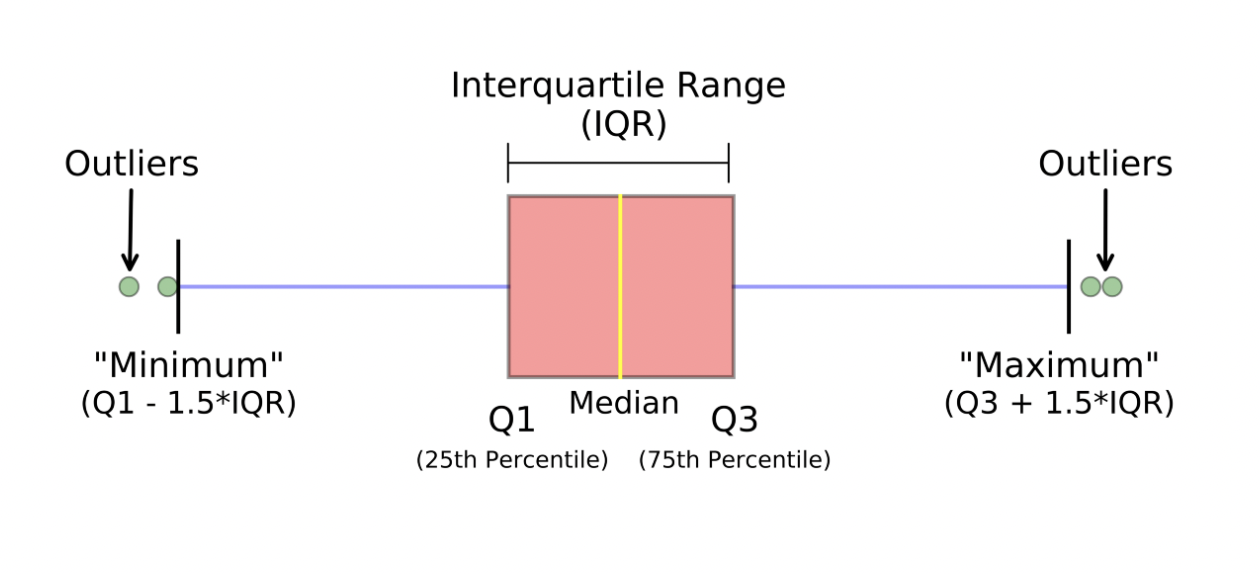

Defining Q3 and Q1 as 75th and 25th is not a rule. It is a common formula but these quartiles can be defined as 95-5, or 90-10 according to the problem. If there is a slight number of data on the dataset, separating it to 75-25% may not be appropriate because the loss of information may occur. 

In light of this information, let's write a function that finds the thresholds. Add the quantiles as arguments because we may want to change them. 


In [96]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [97]:
for i in df.columns:
    print("Thresholds of {} : ({:.2f}, {:.2f})".format(i, *outlier_thresholds(df,i)))

In [98]:
# Observe the outliers, it can be functioned as well, but we don't need here
low, up = outlier_thresholds(df, "Pregnancies")
df[((df["Pregnancies"] < low) | (df["Pregnancies"] > up))]

As mentioned, for Pregnancies, (Q3 + 1.5xIQR) found as 13.5, the upper of these will be considered an outlier. Also, (Q1 - 1.5xIQR) was found as -6.5. Since the minimum value of pregnancy can be 0 logically, there came nothing from the upper threshold as the outlier. 

**NOTE:** LOF method will give an error when there are missing values, so that, explanation and approach with LOF will be explained in part 3. 

### **Missing Values**
<ins>*“The idea of imputation is both seductive and dangerous.” -R.J.A. Little & D.B. Rubin*</ins>

It refers to the situation of lack of observations. It can be solved in 3 ways:
* Deleting
* Value Assignment Methods (average, mode, median, etc.)
* Predictive Methods (ML, statistical methods, etc.)

One of the important issues to consider when working with missing data: The randomness of the missing data, that is, whether the missing data occur randomly or not, is the need to know. If it is random, we either delete it, fill it with the average, etc. However, there may be a dependency of the missing variable with another variable, hence, the missing may not be random. This situation is considered, as well.

In [99]:
df.isnull().values.any()

In [100]:
df.isnull().sum()

At the first look, it seems there is no missing value but Glucose, Insulin, etc. observation units containing a value of 0 in the variables may represent the missing value. For example, a person's glucose or insulin value can not be 0. Considering this situation, let's assign the 0 values to the relevant values as NaN and then apply the operations to the missing values.

Here, the pregnancy value can be 0. It is a normal situation, hence, this column will be out of NaN.

In [101]:
# df before adding NaN
df.head(10)

In [102]:
num_cols_miss = [i for i in num_cols if i != "Pregnancies"]
for i in num_cols_miss:
    df[i] = df.apply(lambda x: np.nan if x[i] == 0 else x[i], axis=1)

In [103]:
# df after adding NaN
df.head(10)

Now, we have missing values, and analysis can be done. Check the missing values again.

In [104]:
df.isnull().sum()

For missing values, there a library named "missingno", which was imported at the beginning. This library provides visual analysis for missing values. 

In [105]:
# the number of non-missing data
msno.bar(df)
plt.show()

In [106]:
"""
y-axis = indexes
x-axis = variables
black = non-missing index
white = missing(NaN) index
In some datasets, relativeness of missing datas on variables can be observed according to whites
"""
msno.matrix(df)
plt.show()

In [107]:
"""
heatmap can be used rather than try to observe with eyes on matrix map
this heatmap shows the correlation of missing values on variables
"""
msno.heatmap(df)
plt.show()

There is an interesting finding that there is a strong positive correlation between "SkinThickness" and "Insulin" variables' missing values. It may be used later.

"missingno" library helps us to visualize the missing values, now let's more mathematical approach. Let's make a table that consists of missing values. For this, write a function that shows the missing values on a dataframe as a table.

In [108]:
def missing_values_table(dataframe, na_name=False):
    # only take missing columns
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)  # number of missing value
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False) # ratio
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])  # make table
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [109]:
missing_values_table(df)

In [110]:
# if column names wants to be stored, na_name argument can be made True
na_cols = missing_values_table(df, na_name=True)
na_cols

Let's create another table that relation between target variable(Outcome) and another variables. 

In [111]:
# We created na_cols above, it can be taken with similar way in function:
# na_columns = [i for i in df.columns if df[i].isnull().sum() > 0]
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()

    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)  # eksiklik varsa 1, yoksa 0 yaz

    # [tüm satırları getir, sütunlarda içinde NA olanları getir]
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")


missing_vs_target(df, "Outcome", na_cols)

On NA_FLAG variables, the missing values are filled with 1, and 0 where there is no missing value. For instance, in Glucose, there are 763 non-missing values and 5 missing values. The mean Outcome for non-missing values is 0.349, and the mean of Outcome for missing values is 0.4.

Why this is significant is because of observation. For example, we may drop "Insulin" because almost half of it missing, but when the relationship between the target is investigated, the mean of disease is much more than non-missing values. The same situation can be observed on SkinThickness. Remember, we found the missing correlation between Insulin and SkinThickness, so that, my opinion is not to drop these at that point. 

The correlation is another approach to look for inversing whether there is a relation.

In [112]:
df_cor = pd.DataFrame([df["Outcome"].corr(df[i]) for i in num_cols], index=num_cols, columns=["Correlation"])
df_cor

The most considerable variable is Glucose, but Insuline may not be ignored even if it has too many missing values because there is a slight correlation, as well.

With this analysis, EDA part is completed.

<a id="3"></a> <br>
# 3. Pre-processing (Solve Outliers and Missing Values)

In part 2, the analysis has been completed. Examination of thresholds for outliers and how to reach missing values have been done. The next step is to interfere with these and prepare the dataset. This part will be separated into 2, like part 2. Firstly, the outliers problem will be examined, then, missing values will be processed. 

Our threshold values can be affected after the operations on the missing value. Also, an outlier method, LOF, cannot be used when the dataset includes NaN values. Therefore, the missing value part will be taken firstly on preprocessing.

### **Missing Values**

It mentioned on analyze part that there is 3 solution to missing values. 

- **Deleting:** It means dropping the rows that include missing values. Especially in a small dataset, it creates a loss of information. For example, the dataset has 768 rows, but Insuline has 374 missing values. If missing values are dropped, half of the dataset has been lost, and the information will be lost, as well. If the dataset would be large, and there are a couple of missing values that can be sacrificed, deleting can be an option.

In [113]:
df_new = df.copy() # copy dataset to see effect without damage the main dataset
df_new.shape

In [114]:
df_new.dropna(inplace=True)
df_new.shape

- **Value Assignment Methods**: We can fill the NaN values with the column's mean, median, mode, etc. If the distribution is homogeneous, filling with median or mean is logical. Also, in some scenarios, filling with a specific number like 0 would make sense.

In [115]:
df_fill = df.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)
df_fill.head(10) # after filling

In [116]:
# before filling
df.head(10)

- **Predictive Methods:** This method is based on machine learning, statistical methods, etc. It is an advanced level to fill NaN values. A model can be implemented and missing values are predicted by that model in this method. There are 2 points we have to consider:

>1. We have to put categorical variables into a one-hot encoder. Since we will use a modeling technique, the model expects variables from us in some specific ways, and we have to comply with these. <br>
2. Since KNN is a distance-based algorithm, we need to standardize the variables.

Encoding and standardization will be explained in the next part, so that, only the predictive method process will be shown in this part. The only point, for now, since all variables are numerical, encoding will not be done. 

In [117]:
df_ml = df.copy()

# standardization
scaler = MinMaxScaler()
df_ml = pd.DataFrame(scaler.fit_transform(df_ml), columns=df_ml.columns)
df_ml.head()

In [118]:
# fill with KNN
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_ml = pd.DataFrame(imputer.fit_transform(df_ml), columns=df_ml.columns)
df_ml.head()

In this way, we have completed the filling process, but the problem is all values we filled become standardized. It can turn the normal values with "inverse_transform".

In [119]:
df_ml = pd.DataFrame(scaler.inverse_transform(df_ml), columns=df_ml.columns)
df_ml.head()

In [120]:
# our first dataset
df.head()

We examined the possible ways to deal with missing data. In order to examine the ways, the methods have been implemented in different data frames. Now, we have to apply these methods to the main dataframe.

Firstly, check again the number of missing values with the function we defined on analyze part.

In [121]:
missing_values_table(df)

Here, my approach will separate the process into 2. Since two variables have many missing values, making a prediction may not be logical for these. It is just an interpretation and this is open to comment. The data preprocessing part is subjective, but the common aim is to prepare data as clearly as possible before the model.

My comment is to use predict model for variables that include a low number of missing values and fill median for variables that have a high number of missing. 

In [122]:
na_cols = missing_values_table(df, na_name=True) # columns that includes missing values
n_miss = df[na_cols].isnull().sum() # number of missing values on variables

# 100 as a threshold, it is open to comment
na_cols_ml = [i for i in n_miss.index if n_miss[i] < 100]
na_cols_med = [i for i in n_miss.index if n_miss[i] > 100]
print("Columns that will be applied ML model:", na_cols_ml)
print("Columns that will be filled with median:", na_cols_med)

In [123]:
# check before process
df.head(10)

In [124]:
# for the number of missing value is less than 100
df[na_cols_med] = df[na_cols_med].apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)
df.head(10)

As it can be seen above, "SkinThickness" and "Insulin" have been filled with their median values. Now, variables that have slight number of missing values will be filled with ML model.

In [125]:
# standardization
scaler = MinMaxScaler()

# take only needed columns
df[na_cols_ml] = pd.DataFrame(scaler.fit_transform(df[na_cols_ml]), columns=df[na_cols_ml].columns)
print(df[na_cols_ml].head())

# fill with KNN
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df[na_cols_ml] = pd.DataFrame(imputer.fit_transform(df[na_cols_ml]), columns=df[na_cols_ml].columns)
print(df[na_cols_ml].head())

# from standardized to non-standardized 
df[na_cols_ml] = pd.DataFrame(scaler.inverse_transform(df[na_cols_ml]), columns=df[na_cols_ml].columns)
print(df[na_cols_ml].head())

In [126]:
df.head(10)

As it can be seen, NaN values are filled. For the last time, check the number of missing values.

In [127]:
df.isnull().sum()

### **Outliers**

We mentioned on analyze part that there are 2 ways to solve this problem: <ins>IQR Method</ins> for the find outliers on univariate, and <ins>LOF Method</ins> for getting multivariate outliers. 

Firstly, LOF Method will be explained because it controls the variables' meaningfulness to each other and gives a few outliers. Then, IQR Method will be implemented.


* **Local Outlier Factor (LOF):** Another approach is the Local Outlier Factor. It helps us to define outliers accordingly by ordering the observations based on the density at their location. The local density of a point means the neighborhoods around that point. If a point is significantly less dense than its neighbors, then that point is in a more sparse region, so there may be an outlier. The LOF method allows us to calculate a distance score based on neighborhoods.

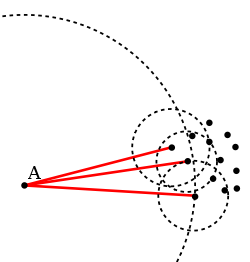

The LOF method says: "I'll give you a score, the closer the score to 1 the better". Therefore, as you move away from 1, the probability of the observation being outlier increases. The LOF method is also used to determine thresholds.

**Example of usage:** In our dataset, there are both "Age" and "Pregnancies". For instance, when these variables are taken separately, there may not be any outlier. However, when these 2 variables get together, it may be the outlier. What it means is explained in the following example dataframe.

In [128]:
df_ex = pd.DataFrame({"age": [17, 35, 47],
                     "pregnancy": [5, 2, 3]})
df_ex

When we take the variables separately, "Age" is looking fine. A person can be 17, 35, or 47 years old. Similarly, "Pregnancy" has no problem if we consider only the number of pregnancies because a person can be pregnant 5 times, twice, or 3 times. 

Now, check the first index, the values have meanings separately, but together, a person 17 years old cannot be pregnant 5 times. This is an outlier row. LOF helps us to find these kinds of values and fix these. 

The LOF scores will be considered, then, <ins>"elbow method"</ins> will be implemented to determine threshold. 

In [129]:
# LOF
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df)  # returns LOF scores
df_scores = clf.negative_outlier_factor_ # keep scores to observe (negative)
# df_scores = -df_scores # for changing to pozitive but we will use as negative
print(df_scores[0:5])
print(np.sort(df_scores)[0:5])

**NOTE:** "negative_outlier_factor_" method gives scores as negative. These can be changed to positive but the original negative values will be used in order to observe it more easily in the elbow method that will be used. Therefore, if scores are close to -1, the result becomes not an outlier, not being close to 1 like at the beginning. For instance, if we have scores from -1 to -10, it will be interpreted that values at -10 tend to be more outlier.

In [130]:
# elbow method
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 20], style='.-')  # x=gözlemler, y=outlier skorları
plt.show()

There are observations on the x-axis and outlier scores on the y-axis. Each point represents threshold values and a graph was created according to these threshold values. The threshold value has to be decided according to the table. The point where the steepest slope change is the 3rd index. Hence, the final comment can be:

There are some observations and their scores, and there is the problem of where to divide these scores. The most marginal change was in the 3rd index, so this is the point where the most drastic change is defined as the threshold value. Because the lower scores(more negative values) are the worse, then a threshold has to be set and cut it.

In [131]:
th = np.sort(df_scores)[3]  # set any lower scores than that as outlier
df[df_scores < th] # check outliers

In [132]:
df.describe([0.01, 0.05, 0.25, 0.50, 0.75, 0.90, 0.99]).T

For instance, for the 13th index, while SkinThickness is close to 25% quantile, Insulin is max. On the 445th index, maybe when Glucose and BMI are close to high values, but Insuline is minimum, and this kind of combination may not be possible. 

Being close(or be exactly) to max or min values are not obligatory. These are just comments without any industry knowledge, maybe these are wrong but these kinds of comments have to be done for understanding the data. 

There is just 3 observation on the data set, so they can be deleted.

In [133]:
print("Before delete outliers:", df.shape)
print(df[df_scores < th].index) # indexes of outliers, just for observation
df.drop(axis=0, labels=df[df_scores < th].index, inplace=True) 
print("After delete outliers:", df.shape)

- **IQR:** We find the thresholds on analysis using IQR calculation. Now, re-assignment with thresholds will be done. It means the outliers will be replaced with upper and lower thresholds. Why this kind of process is made is based on preventing the loss of data. Especially in the small dataset, each data is significant. <br>
<br>
In the literature, the upper limit is taken as 75% quantile(Q3), and a higher value than 1.5xQ3 will be replaced this threshold, a similar process is done with the lower value that is lower than 1.5xQ1, where Q1 is 25% quantile. We can also use quantiles as 5 by 95 because deleting or filling according to 25-75 would create a serious data loss and residue, we would add noise ourselves and create problems. Hence, the proportion of these depends according to the problems and datasets. If tree methods are used, not to touch outliers may be chosen, or approaching unacceptable outliers a shave from the end may be implemented.

In the analysis part, thresholds have been found with the function "outlier_thresholds". Now, write a function that takes these thresholds and makes re-assignment to outliers. 

In [134]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [135]:
# before re-assignment
df.describe().T

In [136]:
for col in num_cols:
    replace_with_thresholds(df, col)

In [137]:
# after re-assignment
df.describe().T

As it can be seen, min, max, event mean, and std values have changed according to thresholds. Solution of outliers has been completed with this process. 

<a id="4"></a> <br>
# 4. Feature Extraction

When a data set is prepared, not only existing variables are tried to be edited, but also new, meaningful variables have to be created. New columns sometimes can be created with mathematical operations, sometimes named a numerical value to categorical, or categorical values' ranges, etc. This process is known as **Feature Engineering**, and this is one of the critical parts of data preparation. 

In [138]:
# pregrancy cannot be float, it occurs due to calculation of IQR
df["Pregnancies"] = df["Pregnancies"].apply(lambda x: int(x))

In [139]:
# create categorical columns from numerical columns

# if bins are 0, 3, 6 => 0 values become NaN due to bins 
df["NumOfPreg"] = pd.cut(df["Pregnancies"], bins=[-1, 3, 6, df["Pregnancies"].max()], labels=["Normal", "Above Normal","Extreme"])
df["AgeGroup"] = pd.cut(df["Age"], bins=[18, 25, 40, df["Age"].max()], labels=["Young", "Mature", "Old"])
df["GlucoseGroup"] = pd.qcut(df["Glucose"], 3, labels=["Low", "Medium", "High"])
df["Patient"] = np.where(df["Outcome"] == 1, "Yes", "No")

In [140]:
# example of mathematical expression

"""Assume there is a variable named "BMIns", and it can be found with the multiplication of BMI and Insuline. 
Create and add it to data frame"""

df["BMIns"] = df["BMI"]*df["Insulin"] # numerical
df["BMInsGroup"] = pd.qcut(df["BMIns"], 3, labels=["Low", "Medium", "High"]) # categorical

In [141]:
df.head()

<a id="5"></a> <br>
# 5. Encoding & Scaling

### **Encoding** 
Changing the representation of variables. There are different types of encoding:
> If there are 2 classes, it is called **"Binary Encoding"**, if there are more than 2 classes, it is called **"Label Encoding"**. 

It converts in alphabetical order, giving 0 to the first one it sees.

In [142]:
df_enc = df.copy()

le = LabelEncoder()
le.fit_transform(df_enc["Patient"])[0:5]

In [143]:
# let's say we forgot which 0 and which 1, inverse_transform is used to detect this
le.inverse_transform([0, 1])

In [144]:
# detect variables that have 2 unique numbers for Binary Encoding
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]
binary_cols

If a variable is converted like this to numeric values and sent to algorithms, the algorithm defines this variable as a variable ranging from an interval. In other words, this transformation will confuse the algorithms. The reason for its corruption is here, the categorical variable has turned into numerical values, and a categorical variable, which is normally a nominal scale type, is suddenly distorted by a transformation process and is subjected to a sorting process as if there is a difference between them. The characteristic of the nominal scale type is that the distance between classes is equal, but this equality is disturbed after this transformation.

This situation can cause biases and problems when we convert categorical variables to numeric values and confuse algorithms. In this case, we need to do **one-hot encoding**.

To fix this problem, one-hot conversion is done, but doing this also creates a trap named as "dummy variable trap." 

If we apply a transformation to the variables in the data set, if the new variables can be created over each other, this is a dummy variable trap. In other words, if there is a variable that represents another variable, this situation is called a dummy variable trap. 

Let's see how one-hot encoding is done, what the dummy variable trap is, and how to fix that.

In [145]:
df.head()

In [146]:
df_new = pd.get_dummies(df, columns=["Patient"])
df_new.head()

As it can be seen, Patient is dropped, and there are new variables: Patient_No and Patient_Yes. The problem is Patient_No is the reverse of the Patient_Yes, which means, Patient_No can be created over Patient_Yes. These both carry the same information, and both are on a data frame. In that situation, we have to drop one of these, and it helps to avoid creating over each other and duplication. The dummy variable trap is solved with this. 

In [147]:
df_new = pd.get_dummies(df, columns=["Patient"], drop_first=True)
df_new.head()

Also, a prefix of the new variables can be defined as an argument.

In [148]:
df_new = pd.get_dummies(df, columns=["Patient"], drop_first=True, prefix=["Sick"])
df_new.head()

Now, apply this method to our main dataset's categorical variables. Firstly, take categorical variables again with the function we write in the analysis part.

In [149]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
cat_cols

The outcome is our target variable, and Patient is the variable created by us. They carry the same info, and I don't want to encode the target variable since the aim of the final model will be to predict that. The rest of the numerical columns can be encoded.

In [150]:
cat_cols_final = [i for i in cat_cols if i not in ["Patient", "Outcome"]]
df = pd.get_dummies(df, columns=cat_cols_final, drop_first=True)
df.head()

### Scaling

It is a variable scaling operation. The aim is to eliminate the measurement difference between the variables and to try to ensure that the models to be used approach the variables under equal conditions. Tree-based methods are not affected by outlier, standardization. In the general trend, we may prefer to scale features.

The variance structure and information structure within the variable itself are not deteriorated, but are set to a certain standard. For example, let's say a dataset has a value of 10 and is ranked 80th when ordered from smallest to largest. When this variable is standardized, the value of 10 will be something like between 1-2 or 0 to 1, but when the data set is again ordered from smallest to largest, this value will still correspond to the 80th value. Therefore, when a variable is standardized, the value of the variable will change, it will be put into a certain format, but the spread and the essence of the distribution information will not change. The values of the variable such as mean, standard deviation and variance will change,as well, but the spread, distribution and current state of the information it carries within the variable will not change.

There are 3 common scaling method:
* **Standard Scaler:** Normalization. Subtract the mean, divide by the standard deviation. It can be called z-standardization. z = (x - u) / s.
> The Standard Scaler subtracts the mean from all observation units and divides it by the standard deviation.<br>
CAUTION: Both standard deviation and mean are metrics that are affected by outliers. Therefore, if we subtract the median from all observation units and divide by the IQR, which is not affected by outliers, we will both consider the central tendency and change, and perform a more robust standardization process.<br>
Robust Scaler is more preferable because it is resistant to outliers compared to Standard Scaler, but its use is not common. Usually Standard Scaler and MinMax are used.

* **Robust Scaler:** Subtract median and divide by IQR.
* **MinMaxScaler:** It is used to convert values between 2 desired ranges. These 2 values may also be values that are not in our dataset.

In [151]:
df.head()

In [152]:
df_scale = df.copy()

# standart scaler
ss = StandardScaler()
df_scale["Age_standard_scaler"] = ss.fit_transform(df_scale[["Age"]])
df_scale.head()

# robust scaler
rs = RobustScaler()
df_scale["Age_robuts_scaler"] = rs.fit_transform(df_scale[["Age"]])

# min-max scaler
# The range can be given with the feature_range=() argument
mms = MinMaxScaler() # default range from 0 to 1
df_scale["Age_min_max_scaler"] = mms.fit_transform(df_scale[["Age"]]) 

df_scale.head()

The difference between scales can be observed above. In this problem, "robust scaler" will be used here. There is no specific reason, simply, all scaling types aim for the same thing, but impact in different ways. 

Also, the process has to be applied to all numerical variables because the main point is the scaling is to remove the difference between variables' ranges.

In [153]:
rs = RobustScaler()
for i in num_cols:
    df[i] = rs.fit_transform(df[[i]])
df.head()

In this way, our data set is ready to model. The model part is not on the topic of data preprocessing and feature engineering, obviously. It's just to observe the effect of data cleaning.

<a id="6"></a> <br><a id="6"></a> <br>
# 6. Model

It is not within the scope of this topic, we are only doing it to see the model establishment while preparing the data.

Patient carries the same information with Outcome. It was created as an example of feature engineering. Also, BMIns is not a real feature, it was another example of feature engineering using mathematical expression. Therefore, these 2 variables will be dropped.

KNN algorithm will be used. 

In [154]:
y = df["Outcome"]
X = df.drop(["Outcome", "Patient", "BMIns", "BMInsGroup_Medium", "BMInsGroup_High"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

### What would be the score without any adjustments?


In [155]:
df_no = pd.read_csv("../input/diabetes/diabetes.csv")
df_no.dropna(inplace=True) # there was no missing value 
# df_no = pd.get_dummies(df_no, columns=[], drop_first=True) # no cat. col. to encode

y = df_no["Outcome"]
X = df_no.drop(["Outcome"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

## FINAL

In this project, the steps of preprocessing and data preparation has been explained. The effect of how a dataset cleaning affect the model performance was observed at the end of the project. This is the end of the tutorial, I hope it helped. Thanks for reading!